In [32]:
import os
import random
import numpy as np
from PIL import Image
from glob import glob
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

In [33]:
# 데이터 경로
data_dir = './train'

In [34]:
# utils
def is_image_file(filename):
    IMG_EXTENSIONS = [
        '.jpg', '.JPG', '.jpeg', '.JPEG',
        '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP', 'tif', 'tiff'
    ]
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def make_dataset(dir, max_dataset_size=float("inf")):
    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir

    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            if is_image_file(fname):
                path = os.path.join(root, fname)
                images.append(path)
    return images[:min(max_dataset_size, len(images))]

In [35]:
x = make_dataset(os.path.join(data_dir, 'x'))
y = make_dataset(os.path.join(data_dir, 'y'))
print("데이터 수")
print(f"x : {len(x)}")
print(f"y : {len(y)}")
# x = x[start_idx:end_idx]
# y = y[start_idx:end_idx]

# print()
# print(f"x : {len(x)}")

데이터 수
x : 12000
y : 12000


In [36]:
label = Image.open(y[0])

In [37]:
print(np.array(label).shape)

(754, 1508)


# 데이터 사이즈

In [38]:
width_count = defaultdict(int)
height_count = defaultdict(int)
x_np_list = []
y_np_list = []
for idx, (x_file, y_file) in enumerate(zip(x, y)):
    x_np = np.array(Image.open(x_file))
    y_np = np.array(Image.open(y_file))
    if x_np.shape[0] != y_np.shape[0]:
        print(idx, x_np.shape[0], y_np.shape[0])
    if x_np.shape[1] != y_np.shape[1]:
        print(idx, x_np.shape[1], y_np.shape[1])
    width_count[x_np.shape[1]] += 1
    height_count[x_np.shape[0]] += 1
    x_np_list.append(x_np)
    y_np_list.append(y_np)

3290 750 754
3290 1500 1508
6088 750 754
6088 1500 1508
6590 750 754
6590 1500 1508
9357 750 754
9357 1500 1508
9706 750 754
9706 1500 1508


In [39]:
print(width_count)
print(height_count)

defaultdict(<class 'int'>, {1508: 11947, 1500: 53})
defaultdict(<class 'int'>, {754: 11947, 750: 53})


- 이미지, 라벨 사이즈
  - (1508, 754) , (1500, 750)
- 노이즈? (이미지 사이즈와 라벨 사이즈가 맞지 않음)
  - idx = 3290, 6088, 6590, 9357, 9706
  - resize한다면 크게 중요하지 않을듯
  - 전처리때만 조심

- lebel 1 : 신축(new)
- lebel 2 : 소멸(extinction)
- lebel 3 : 갱신(renewal)

# label 확인

In [43]:
label_count = defaultdict(int)
for y_np in y_np_list:
    if 1 in y_np:
        label_count[1] += 1
        if 2 in y_np or 3 in y_np:
            label_count["multi"] += 1
    if 2 in y_np:
        label_count[2] += 1
        if 1 in y_np or 3 in y_np:
            label_count["multi"] += 1
    if 3 in y_np:
        label_count[3] += 1
        if 1 in y_np or 2 in y_np:
            label_count["multi"] += 1
    if (not 1 in y_np) and (not 2 in y_np) and (not 3 in y_np):
        label_count["None"] += 1
print(label_count)

defaultdict(<class 'int'>, {3: 10605, 2: 821, 1: 1609, 'multi': 2048, 'None': 4})


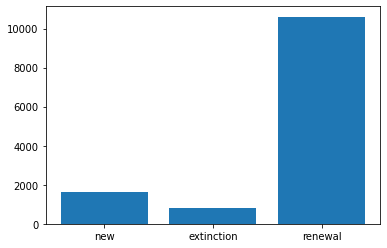

1609 821 10605


In [69]:
plt.figure()
label = ['new', 'extinction', 'renewal']
plt.bar(label, [label_count[1], label_count[2], label_count[3]])
plt.show()
print(label_count[1], label_count[2], label_count[3])

- Imbalance Label 경향
  - 한 이미지에 하나만 측정한 것이므로 정확하지 않음
- Multi label
  - 2048장은 한 이미지에 2개 이상의 label이 있음
- label이 없는 이미지 4장

# Label 평균 위치

In [65]:
label_1_mean_pos_list = {'width':[], 'height':[]}
label_2_mean_pos_list = {'width':[], 'height':[]}
label_3_mean_pos_list = {'width':[], 'height':[]}

for y_np in y_np_list:
    height_1, width_1 = np.where(y_np == 1)
    height_2, width_2 = np.where(y_np == 2)
    height_3, width_3 = np.where(y_np == 3)
    
    if height_1.size != 0 or width_1.size != 0:
        height_1 = np.mean(height_1)
        width_1 = np.mean(width_1)
        label_1_mean_pos_list['width'].append(width_1)
        label_1_mean_pos_list['height'].append(height_1)
    
    if height_2.size != 0 or width_2.size != 0:
        height_2 = np.mean(height_2)
        width_2 = np.mean(width_2)
        label_2_mean_pos_list['width'].append(width_2)
        label_2_mean_pos_list['height'].append(height_2)
        
    if height_3.size != 0 or width_3.size != 0:
        height_3 = np.mean(height_3)
        width_3 = np.mean(width_3)
        label_3_mean_pos_list['width'].append(width_3)
        label_3_mean_pos_list['height'].append(height_3)

print(len(label_1_mean_pos_list['width']), len(label_2_mean_pos_list['width']), len(label_3_mean_pos_list['width']))

1609 821 10605


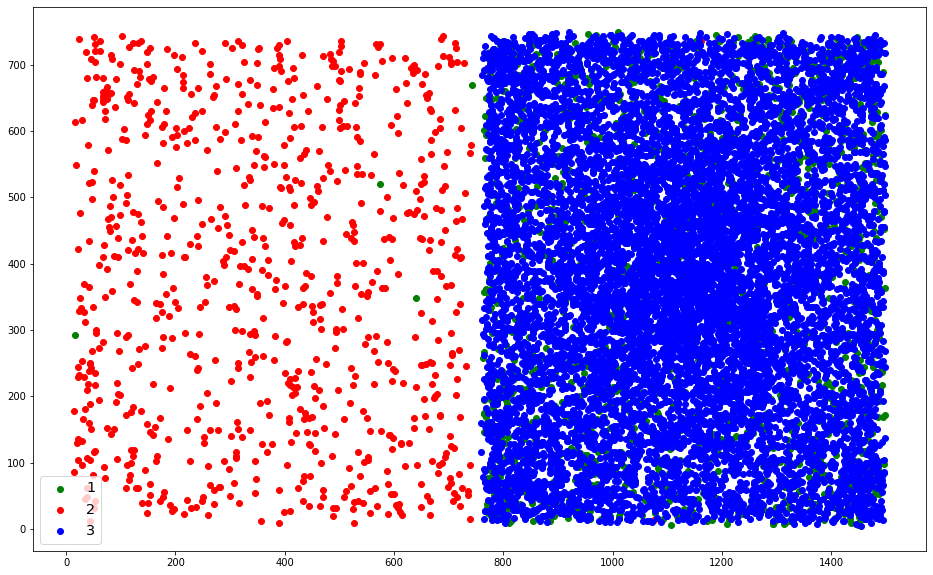

In [67]:
plt.figure(figsize=(16,10))
plt.scatter(label_1_mean_pos_list['width'], label_1_mean_pos_list['height'], c='green', label='1')
plt.scatter(label_2_mean_pos_list['width'], label_2_mean_pos_list['height'], c='red', label='2')
plt.scatter(label_3_mean_pos_list['width'], label_3_mean_pos_list['height'], c='blue', label='3')
plt.legend(fontsize='x-large')
plt.show()

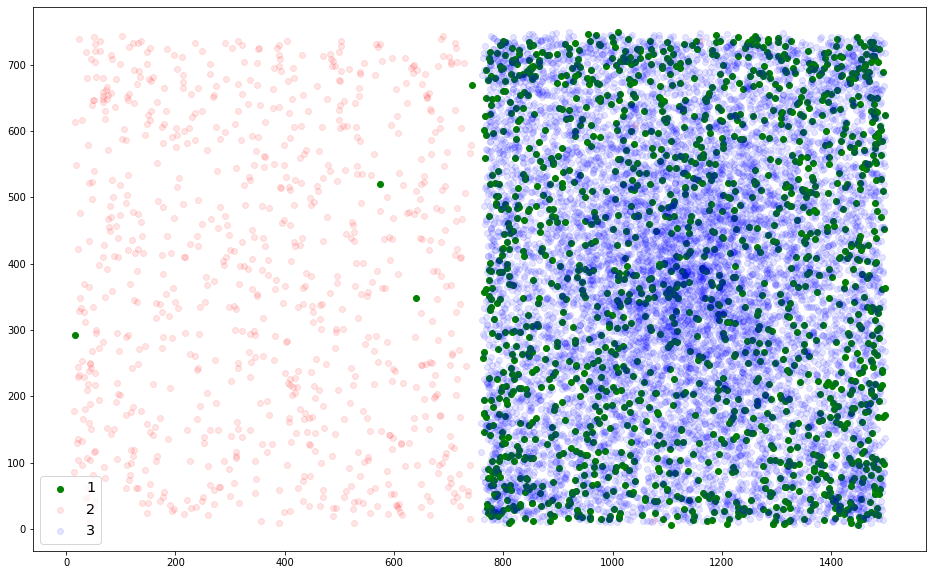

In [73]:
plt.figure(figsize=(16,10))
plt.scatter(label_1_mean_pos_list['width'], label_1_mean_pos_list['height'], c='green', label='1', alpha=1.0)
plt.scatter(label_2_mean_pos_list['width'], label_2_mean_pos_list['height'], c='red', label='2', alpha=0.1)
plt.scatter(label_3_mean_pos_list['width'], label_3_mean_pos_list['height'], c='blue', label='3', alpha=0.1)
plt.legend(fontsize='x-large')
plt.show()

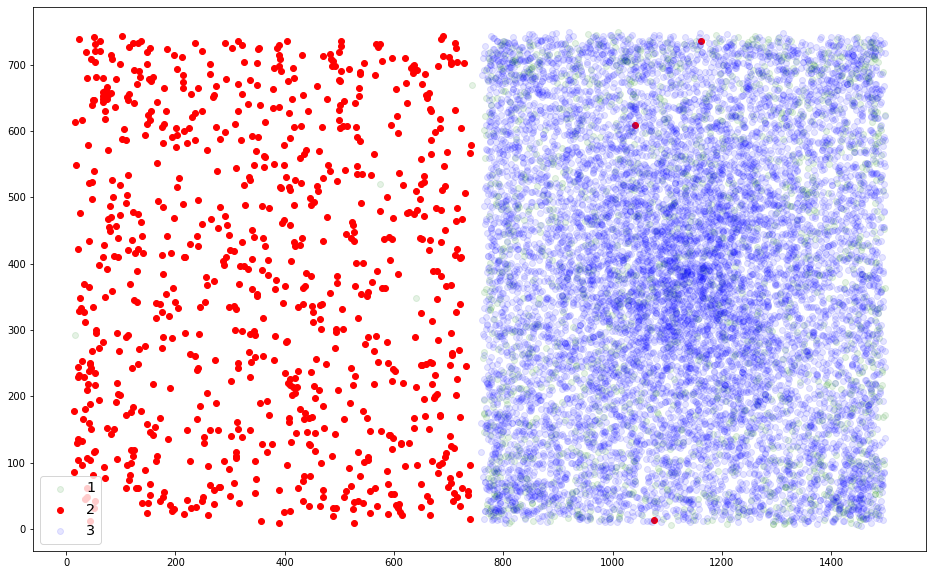

In [74]:
plt.figure(figsize=(16,10))
plt.scatter(label_1_mean_pos_list['width'], label_1_mean_pos_list['height'], c='green', label='1', alpha=0.1)
plt.scatter(label_2_mean_pos_list['width'], label_2_mean_pos_list['height'], c='red', label='2', alpha=1.0)
plt.scatter(label_3_mean_pos_list['width'], label_3_mean_pos_list['height'], c='blue', label='3', alpha=0.1)
plt.legend(fontsize='x-large')
plt.show()

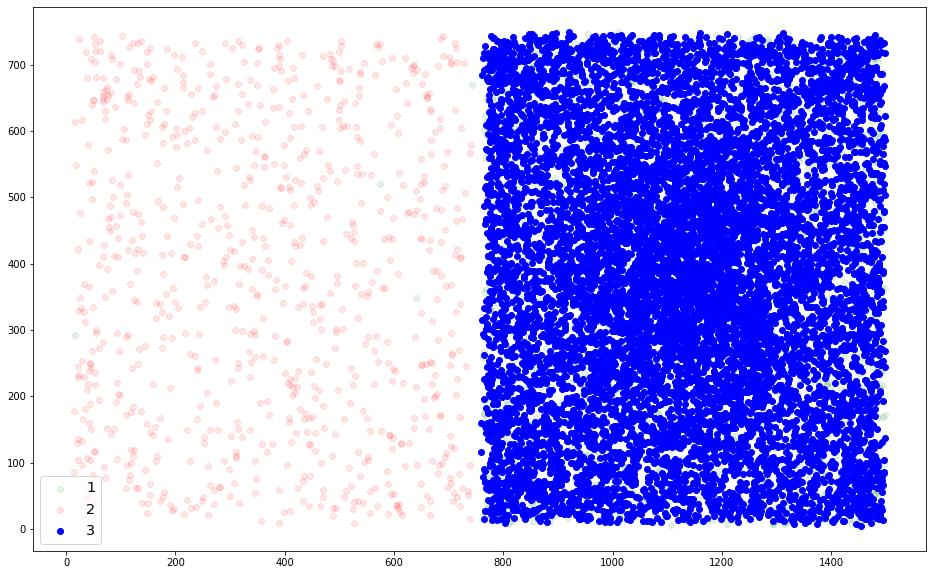

In [75]:
plt.figure(figsize=(16,10))
plt.scatter(label_1_mean_pos_list['width'], label_1_mean_pos_list['height'], c='green', label='1', alpha=0.1)
plt.scatter(label_2_mean_pos_list['width'], label_2_mean_pos_list['height'], c='red', label='2', alpha=0.1)
plt.scatter(label_3_mean_pos_list['width'], label_3_mean_pos_list['height'], c='blue', label='3', alpha=1.0)
plt.legend(fontsize='x-large')
plt.show()

- Label 평균 위치
  - 1 : 오른쪽
  - 2 : 왼쪽
  - 3 : 오른쪽
  - 1, 2 같은 경우 몇개는 반대편에 존재하기도 함
- 주의 : 한 이미지당 존재하는 다양한 라벨의 평균 위치를 찍은 것 이므로 왼쪽과 오른쪽에 동시에 존재할 수 도 있음